## Try to replicate SMT

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *


# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is enabled!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is enabled!")



MPS is enabled!


### 1. Generate data from Archimedean spiral

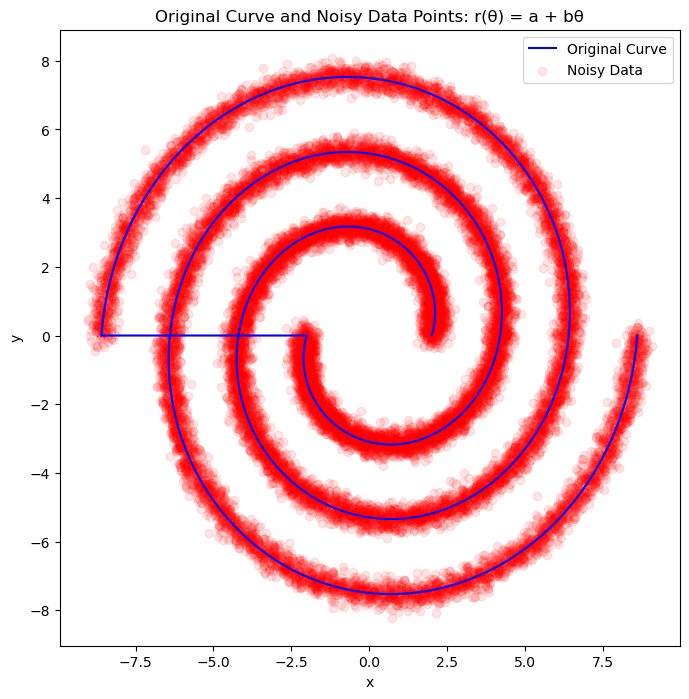

In [2]:
data = GenerateDataset()

## Sparse coding

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class SparseCoding():
    def __init__(self, data_size, activ_dim, basisfunc_num, sparsity_level):
        super(SparseCoding, self).__init__()
        self.Basis = torch.randn(basisfunc_num, activ_dim, requires_grad=True, device = device)
        self.Activ = torch.randn(data_size, basisfunc_num, requires_grad=False, device = device) #manually update A
        self.sparsity_level = sparsity_level

    def loss(self,data):
        reconstruction = self.Activ @ self.Basis

        # Compute the squared differences
        squared_error= (reconstruction - data) ** 2

        # Compute the sum of squared differences
        sum_squared_error = torch.sum(squared_error)

        # Compute the number of samples
        num_samples = data.shape[0]

        return sum_squared_error/num_samples
    
    def activ_panalty(self):
        return self.sparsity_level * torch.norm(abs(self.Activ), p=0.5) 

    def plot_basis(self):
        # Plotting in polar coordinates
        plt.figure(figsize=[6, 6])

        # Detach the tensor before converting to numpy
        basis_np = self.Basis.detach().cpu().numpy()

        # plot dictionary elements
        ax = plt.subplot(111)
        ax.scatter(basis_np[:, 0], basis_np[:, 1], label='landmarks', color='blue')

        # Setting the title and labels
        ax.set_title("Landmarks learnt by Sparse coding")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend()

        # Show the plot
        plt.show()


data_tensor = torch.tensor(data, dtype=torch.float,device = device)
# Create an instance of SparseCoding model
model = SparseCoding(data_size=data_tensor.shape[0], activ_dim=data_tensor.shape[1], basisfunc_num=12, sparsity_level=0)



In [4]:
dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
print(dist.shape)
min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each row
print(min_indices.shape)
model.Activ.zero_()
model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

print(model.Activ.shape)

torch.Size([21600, 12])
torch.Size([21600])
torch.Size([21600, 12])


In [5]:
# Define optimizer
optimizer = optim.Adam([model.Activ, model.Basis], lr=0.01)

# Number of optimization steps
num_epochs = 200

# Training loop
for epoch in range(num_epochs):


    # Update A
    dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
    min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each row
    model.Activ.zero_()
    model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

    # Update B
    cost = model.loss(data_tensor)
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Cost = {cost}')

# After training, you can use the learned dictionary to encode new data
encoded_data = model.Activ @ model.Basis
print("Encoded data shape:", encoded_data.shape)


print(model.Basis.shape)





Epoch [10/200], Cost = 18.115697860717773
Epoch [20/200], Cost = 17.303590774536133
Epoch [30/200], Cost = 16.51979637145996
Epoch [40/200], Cost = 15.768233299255371
Epoch [50/200], Cost = 15.049510955810547
Epoch [60/200], Cost = 14.347983360290527
Epoch [70/200], Cost = 13.648365020751953
Epoch [80/200], Cost = 12.967694282531738
Epoch [90/200], Cost = 12.325079917907715
Epoch [100/200], Cost = 11.728936195373535
Epoch [110/200], Cost = 11.178808212280273
Epoch [120/200], Cost = 10.664501190185547
Epoch [130/200], Cost = 10.17922592163086
Epoch [140/200], Cost = 9.70733642578125
Epoch [150/200], Cost = 9.241233825683594
Epoch [160/200], Cost = 8.778046607971191
Epoch [170/200], Cost = 8.302238464355469
Epoch [180/200], Cost = 7.798151016235352
Epoch [190/200], Cost = 7.271582126617432
Epoch [200/200], Cost = 6.774752616882324
Encoded data shape: torch.Size([21600, 2])
torch.Size([12, 2])


tensor(6.7286, device='mps:0', grad_fn=<DivBackward0>)


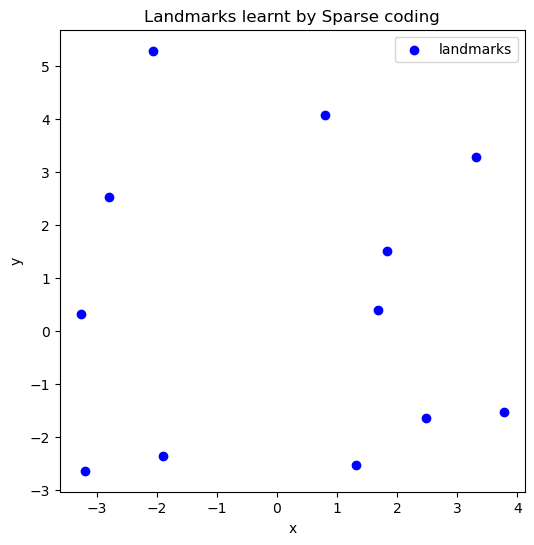

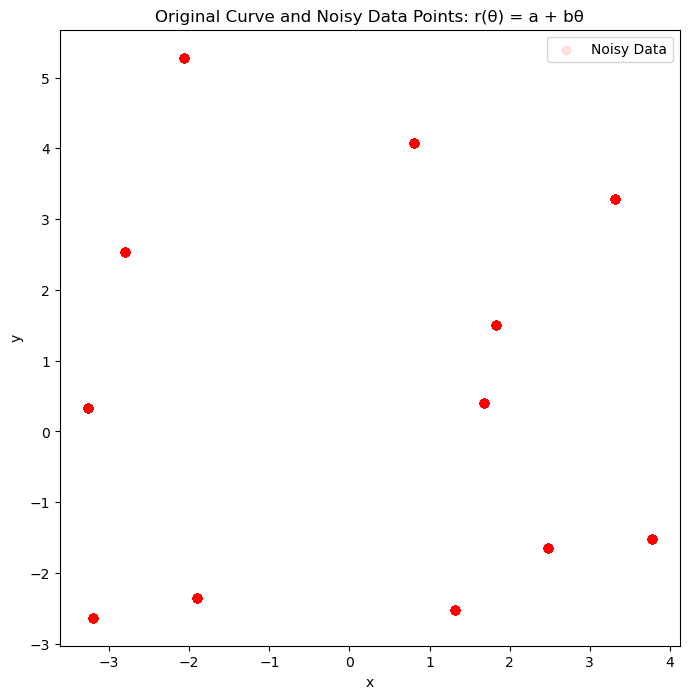

1.0


In [8]:
print(model.loss(data_tensor))


# # Compute the squared differences
# squared_error= (reconstruction - data) ** 2

# # Compute the sum of squared differences
# sum_squared_error = torch.sum(squared_error)

# # Compute the number of samples
# num_samples = data.shape[0]

# return sum_squared_error/num_samples
Bas = model.Basis.detach().cpu()
Act = model.Activ.detach().cpu()

recon = Act @ Bas
# Plotting in polar coordinates

# Original curve label='Original Curve', color='blue')
model.plot_basis()

plt.figure(figsize=[8, 8])

# Noisy data points
ax = plt.subplot(111)
ax.scatter(recon[:, 0], recon[:, 1], label='Noisy Data', color='red', alpha=0.1)

# Setting the title and labels
ax.set_title("Original Curve and Noisy Data Points: r(θ) = a + bθ")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Show the plot

print(np.linalg.norm(Act[0,:]))


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([-3.2636,  0.3247])
torch.Size([12])
tensor(1.)


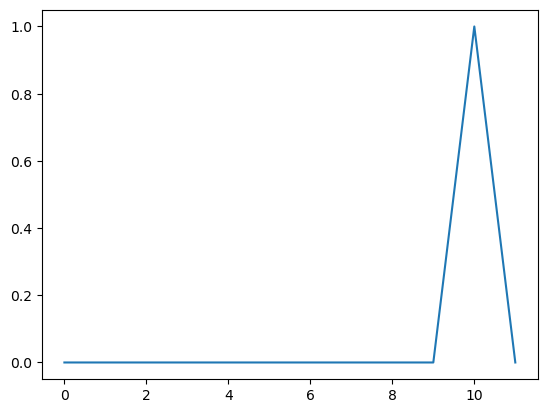

In [7]:
idx = 2034
print(Act[idx])
print(Act[idx] @ Bas)

vec = Act[idx] * Bas[:,0]
print(Act[idx].shape)
print(torch.norm(Act[idx],p=1))
plt.plot(Act[idx])
# plt.plot(Bas[:,0])